
# **Laboratorio 9 — Spark MLlib (Colab)**
**Tema:** ML no supervisado (Correlaciones, PCA, KMeans) y supervisado (Clasificación y Regresión) con PySpark.  
**Datos:** Parquet generados en el **Lab 8** (`/content/drive/MyDrive/Lab8/resultados`).  
**Alumno:** Diedrich SolIS

**Año:** 2025


## 0) Configuración del entorno (Colab + Spark)

In [1]:


from google.colab import drive
drive.mount('/content/drive')


from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("Lab9_Spark_MLlib_Colab")
         .getOrCreate())

print("Spark version:", spark.version)


Mounted at /content/drive
Spark version: 3.5.1



## 1) Carga de datos (Parquet desde Lab 8) y preparación
- Se espera que ya existan los archivos Parquet/CSV del Lab 8 en: `/content/drive/MyDrive/Lab8`
- Aquí reconstruimos DataFrames normalizados como base para ML.


In [2]:

from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, StringType
from pathlib import Path

BASE_L8 = "/content/drive/MyDrive/Lab8"
STAGING = f"{BASE_L8}/_staging_csv"
RESULTS = f"{BASE_L8}/resultados"

print("STAGING:", STAGING)
print("RESULTS:", RESULTS)

def load_cat(cat_dir):
    p = Path(f"{STAGING}/{cat_dir}")
    if p.exists():
        files = list(p.glob("*.csv"))
        if files:
            df = spark.read.option("header", True).csv(str(p / "*.csv"))
            print("CSV cargado:", str(p / "*.csv"))
            return df
    print("No se encontraron CSV en:", str(p / "*.csv"))
    return None

df_hechos_raw     = load_cat("hechos_de_transito")
df_vehiculos_raw  = load_cat("vehiculos_involucrados")
df_fallecidos_raw = load_cat("fallecidos")

def digits_or_null(col):
    cleaned = F.regexp_replace(F.col(col).cast("string"), r"[^0-9]", "")
    return F.when(F.length(cleaned) > 0, cleaned).otherwise(None)

def normalize_df(df):
    if df is None: return None
    cols = df.columns
    y = "anio" if "anio" in cols else ("ano_ocu" if "ano_ocu" in cols else None)
    m = "mes" if "mes" in cols else ("mes_ocu" if "mes_ocu" in cols else None)
    d = "dia" if "dia" in cols else ("dia_ocu" if "dia_ocu" in cols else None)
    h = "hora" if "hora" in cols else ("hora_ocu" if "hora_ocu" in cols else None)

    if y: df = df.withColumn("anio", digits_or_null(y).cast("int"))
    if m: df = df.withColumn("mes", digits_or_null(m).cast("int"))
    if d: df = df.withColumn("dia", digits_or_null(d).cast("int"))
    if h: df = df.withColumn("hora", digits_or_null(h).cast("int"))

    def norm(target, *cands):
        for c in cands:
            if c in cols:
                return df.withColumn(target, F.lower(F.trim(F.col(c))))
        return df

    df = norm("departamento", "departamento", "depto_ocu")
    df = norm("municipio", "municipio", "mupio_ocu")
    df = norm("zona", "zona", "zona_ocu")
    df = norm("tipo_accidente", "tipo_accidente", "tipo_eve")
    df = norm("dia_semana", "dia_semana", "dia_sem_ocu")
    df = norm("sexo_conductor", "sexo_conductor", "sexo_per")
    df = norm("fall_les", "fall_les")
    df = norm("int_o_noint", "int_o_noint")
    df = norm("edad_conductor", "edad_conductor", "edad_per", "edad")
    return df

df_hechos_std     = normalize_df(df_hechos_raw)
df_vehiculos_std  = normalize_df(df_vehiculos_raw)
df_fallecidos_std = normalize_df(df_fallecidos_raw)

def filter_years(df):
    return df.filter((F.col("anio")>=2013) & (F.col("anio")<=2023)) if (df is not None and "anio" in df.columns) else df

df_hechos_f     = filter_years(df_hechos_std)
df_vehiculos_f  = filter_years(df_vehiculos_std)
df_fallecidos_f = filter_years(df_fallecidos_std)

print("Hechos:", df_hechos_f.count() if df_hechos_f is not None else 0)
print("Vehículos:", df_vehiculos_f.count() if df_vehiculos_f is not None else 0)
print("Fallecidos:", df_fallecidos_f.count() if df_fallecidos_f is not None else 0)


STAGING: /content/drive/MyDrive/Lab8/_staging_csv
RESULTS: /content/drive/MyDrive/Lab8/resultados
CSV cargado: /content/drive/MyDrive/Lab8/_staging_csv/hechos_de_transito/*.csv
CSV cargado: /content/drive/MyDrive/Lab8/_staging_csv/vehiculos_involucrados/*.csv
CSV cargado: /content/drive/MyDrive/Lab8/_staging_csv/fallecidos/*.csv
Hechos: 56820
Vehículos: 76320
Fallecidos: 79699



## 2) Ingeniería de características y dataset unificado


In [7]:

from pyspark.sql import functions as F


MES_MAP = {
    "enero":1,"febrero":2,"marzo":3,"abril":4,"mayo":5,"junio":6,
    "julio":7,"agosto":8,"septiembre":9,"setiembre":9,"octubre":10,"noviembre":11,"diciembre":12
}

def ensure_mes_numeric(df):
    """
    Crea/normaliza la columna mes (1..12) a partir de:
      - si ya hay 'mes' pero es texto o viene sucio -> lo limpia
      - si existe 'mes_str' o 'mes_ocu' -> las mapea a número
      - si 'mes' trae dígitos dentro de un string -> extrae dígitos
    """
    if df is None:
        return None

    mapping_expr = F.create_map(*[x for kv in MES_MAP.items() for x in (F.lit(kv[0]), F.lit(kv[1]))])

    def map_from_col(colname):
        return mapping_expr.getItem(F.lower(F.trim(F.col(colname).cast("string"))))


    if "mes" in df.columns:
        df = df.withColumn(
            "mes_tmp",
            F.when(F.col("mes").cast("int").isNotNull(), F.col("mes").cast("int"))
             .when(F.lower(F.col("mes").cast("string")).rlike("^[0-9]+$"), F.col("mes").cast("int"))
             .otherwise(map_from_col("mes"))
        )
    else:
        df = df.withColumn("mes_tmp", F.lit(None).cast("int"))


    if "mes_str" in df.columns:
        df = df.withColumn("mes_tmp", F.when(F.col("mes_tmp").isNull(), map_from_col("mes_str")).otherwise(F.col("mes_tmp")))
    if "mes_ocu" in df.columns:

        df = df.withColumn(
            "mes_tmp",
            F.when(
                F.col("mes_tmp").isNull() & F.lower(F.col("mes_ocu").cast("string")).rlike("^[0-9]+$"),
                F.col("mes_ocu").cast("int")
            ).otherwise(F.col("mes_tmp"))
        ).withColumn(
            "mes_tmp",
            F.when(F.col("mes_tmp").isNull(), map_from_col("mes_ocu")).otherwise(F.col("mes_tmp"))
        )

    df = df.withColumn("mes", F.col("mes_tmp").cast("int")).drop("mes_tmp")
    return df

df_hechos_f     = ensure_mes_numeric(df_hechos_f)
df_vehiculos_f  = ensure_mes_numeric(df_vehiculos_f)
df_fallecidos_f = ensure_mes_numeric(df_fallecidos_f)


def normalize_text(df, cols):
    if df is None: return None
    for c in cols:
        if c in df.columns:
            df = df.withColumn(c, F.lower(F.trim(F.col(c).cast("string"))))
            df = df.withColumn(c, F.regexp_replace(F.col(c), r"[^a-záéíóúñ0-9 ]", ""))
            df = df.withColumn(c, F.regexp_replace(F.col(c), r"\s+", " "))
    return df

TEXT_COLS = ["departamento", "municipio", "zona", "tipo_accidente", "dia_semana"]
df_hechos_f     = normalize_text(df_hechos_f, TEXT_COLS)
df_vehiculos_f  = normalize_text(df_vehiculos_f, TEXT_COLS)
df_fallecidos_f = normalize_text(df_fallecidos_f, TEXT_COLS)



keys_am = ["anio", "mes"]

veh_por = (df_vehiculos_f.groupBy(keys_am)
           .agg(F.count(F.lit(1)).alias("n_vehiculos"))) if df_vehiculos_f is not None else None

fall_por = (df_fallecidos_f
            .filter(F.lower(F.col("fall_les")).like("%fallec%"))
            .groupBy(keys_am)
            .agg(F.count(F.lit(1)).alias("n_fallecidos")) ) if df_fallecidos_f is not None else None

les_por  = (df_fallecidos_f
            .filter(F.lower(F.col("fall_les")).like("%lesion%"))
            .groupBy(keys_am)
            .agg(F.count(F.lit(1)).alias("n_lesionados")) ) if df_fallecidos_f is not None else None


df_ml = df_hechos_f
for piece in [veh_por, fall_por, les_por]:
    if piece is not None:
        df_ml = df_ml.join(piece, on=keys_am, how="left")

df_ml = df_ml.fillna({"n_vehiculos":0, "n_fallecidos":0, "n_lesionados":0})


print("Dataset ML (filas):", df_ml.count())
print("Muestra de llaves + conteos (espera ver >0 en n_fallecidos y n_lesionados):")
df_ml.select(*keys_am, "n_vehiculos", "n_fallecidos", "n_lesionados") \
    .orderBy(F.col("n_fallecidos").desc(), F.col("n_lesionados").desc()) \
    .show(20, truncate=False)

print("Totales y filas con conteos > 0:")
df_ml.agg(
    F.sum(F.when(F.col("n_vehiculos")  > 0, 1).otherwise(0)).alias("filas_con_vehiculos"),
    F.sum(F.when(F.col("n_fallecidos") > 0, 1).otherwise(0)).alias("filas_con_fallecidos"),
    F.sum(F.when(F.col("n_lesionados") > 0, 1).otherwise(0)).alias("filas_con_lesionados"),
    F.sum("n_vehiculos").alias("total_vehiculos"),
    F.sum("n_fallecidos").alias("total_fallecidos"),
    F.sum("n_lesionados").alias("total_lesionados")
).show(truncate=False)


/usr/local/lib/python3.12/dist-packages/pyspark/sql/column.py:460: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  warnings.warn(


Dataset ML (filas): 56820
Muestra de llaves + conteos (espera ver >0 en n_fallecidos y n_lesionados):
+----+---+-----------+------------+------------+
|anio|mes|n_vehiculos|n_fallecidos|n_lesionados|
+----+---+-----------+------------+------------+
|2023|12 |1223       |255         |887         |
|2023|12 |1223       |255         |887         |
|2023|12 |1223       |255         |887         |
|2023|12 |1223       |255         |887         |
|2023|12 |1223       |255         |887         |
|2023|12 |1223       |255         |887         |
|2023|12 |1223       |255         |887         |
|2023|12 |1223       |255         |887         |
|2023|12 |1223       |255         |887         |
|2023|12 |1223       |255         |887         |
|2023|12 |1223       |255         |887         |
|2023|12 |1223       |255         |887         |
|2023|12 |1223       |255         |887         |
|2023|12 |1223       |255         |887         |
|2023|12 |1223       |255         |887         |
|2023|12 |1223  

## 3) **No supervisado** (Correlaciones, PCA, KMeans) — *(25 pts)*

### 3.1) Correlaciones

In [8]:

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

num_cols = [c for c in ["hora","mes","n_vehiculos","n_fallecidos","n_lesionados"] if c in df_ml.columns]
assembler_corr = VectorAssembler(inputCols=num_cols, outputCol="features_corr")
df_corr = assembler_corr.transform(df_ml.select(*num_cols).dropna())

corr_mat = Correlation.corr(df_corr, "features_corr").head()[0].toArray()
print("Columnas:", num_cols)
print("Matriz de correlación:\n", corr_mat)


Columnas: ['hora', 'mes', 'n_vehiculos', 'n_fallecidos', 'n_lesionados']
Matriz de correlación:
 [[ 1.         -0.03458543 -0.07681163 -0.04940427 -0.04778219]
 [-0.03458543  1.          0.35658334  0.08415212  0.04964328]
 [-0.07681163  0.35658334  1.          0.38673316  0.39034263]
 [-0.04940427  0.08415212  0.38673316  1.          0.99056818]
 [-0.04778219  0.04964328  0.39034263  0.99056818  1.        ]]


### 3.2) PCA (2 componentes)

Explained variance (2 comp.): [0.69472172 0.30447041]


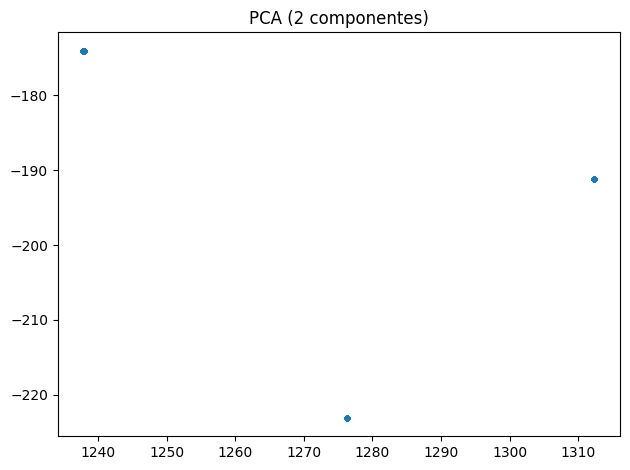

In [9]:

from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt

assembler_pca = VectorAssembler(inputCols=num_cols, outputCol="features_pca")
df_pca_in = assembler_pca.transform(df_ml.select(*num_cols).dropna())

pca = PCA(k=2, inputCol="features_pca", outputCol="pca")
pca_model = pca.fit(df_pca_in)
df_pca_out = pca_model.transform(df_pca_in)
print("Explained variance (2 comp.):", pca_model.explainedVariance.toArray())

pdf_pca = df_pca_out.select("pca").limit(2000).toPandas()
xs = [v[0] for v in pdf_pca["pca"]]
ys = [v[1] for v in pdf_pca["pca"]]

plt.figure()
plt.scatter(xs, ys, s=8)
plt.title("PCA (2 componentes)")
plt.tight_layout(); plt.show()


### 3.3) KMeans (k=3,4) y selección de k

k=3, silhouette=0.917302987856178
k=4, silhouette=0.8458193887671116
Mejor k por silhouette: 3


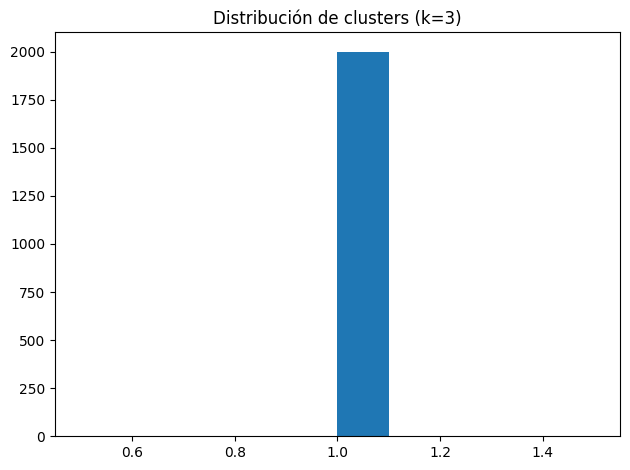

In [10]:

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

df_k = df_pca_in

metrics = []
for k in [3,4]:
    kmeans = KMeans(k=k, seed=42, featuresCol="features_pca", predictionCol="cluster")
    model = kmeans.fit(df_k)
    pred = model.transform(df_k)
    evaluator = ClusteringEvaluator(featuresCol="features_pca", predictionCol="cluster")
    silhouette = evaluator.evaluate(pred)
    metrics.append((k, silhouette))
    print(f"k={k}, silhouette={silhouette}")

best_k = max(metrics, key=lambda x: x[1])[0] if metrics else 3
print("Mejor k por silhouette:", best_k)

final_model = KMeans(k=best_k, seed=42, featuresCol="features_pca", predictionCol="cluster").fit(df_k)
pred_best = final_model.transform(df_k)

pdf_k = pred_best.select("cluster").limit(2000).toPandas()
plt.figure()
plt.hist(pdf_k["cluster"])
plt.title(f"Distribución de clusters (k={best_k})")
plt.tight_layout(); plt.show()


## 4) **Supervisado** — Clasificación (RF, LR, DT) — *(40 pts)*

In [21]:


from pyspark.sql import functions as F

df_ml = (df_ml
    .withColumn(
        "severidad",
        F.when((F.col("n_fallecidos") == 0) & (F.col("n_lesionados") < 2), F.lit("Leve"))
         .when((F.col("n_fallecidos") == 1) | ((F.col("n_lesionados") >= 2) & (F.col("n_lesionados") <= 5)), F.lit("Moderado"))
         .otherwise(F.lit("Grave"))
    )
)

print("Distribución de severidad:")
df_ml.groupBy("severidad").count().orderBy("severidad").show()


Distribución de severidad:
+---------+-----+
|severidad|count|
+---------+-----+
|    Grave|16142|
|     Leve|40678|
+---------+-----+



In [25]:
from pyspark.sql import functions as F, types as T
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, Imputer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

df = df_ml


if "severidad" not in df.columns:
    df = (df
        .withColumn(
            "severidad",
            F.when((F.col("n_fallecidos") == 0) & (F.col("n_lesionados") < 2), F.lit("Leve"))
             .when((F.col("n_fallecidos") == 1) | ((F.col("n_lesionados") >= 2) & (F.col("n_lesionados") <= 5)), F.lit("Moderado"))
             .otherwise(F.lit("Grave"))
        )
    )


cat_raw = [c for c in ["tipo_accidente","departamento","zona","dia_semana"] if c in df.columns]


existing_idx = [c for c in df.columns if c.endswith("_idx")]
cat_idx_existing = [f"{c}_idx" for c in cat_raw if f"{c}_idx" in existing_idx]
cat_to_index = [c for c in cat_raw if f"{c}_idx" not in existing_idx]
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_idx2", handleInvalid="keep") for c in cat_to_index]
cat_idx_new = [f"{c}_idx2" for c in cat_to_index]
cat_idx_all = cat_idx_existing + cat_idx_new


num_candidates = {
    "hora": ["hora_double","hora"],
    "mes": ["mes_double","mes"],
    "n_vehiculos": ["n_vehiculos_double","n_vehiculos"],
    "n_fallecidos": ["n_fallecidos_double","n_fallecidos"],
    "n_lesionados": ["n_lesionados_double","n_lesionados"],
}
num_cols = []
for base, options in num_candidates.items():
    for opt in options:
        if opt in df.columns:
            num_cols.append(opt)
            break


for c in num_cols:
    df = df.withColumn(c, F.col(c).cast(T.DoubleType()))


imp_out = [f"{c}_imp" for c in num_cols]
imputer = Imputer(inputCols=num_cols, outputCols=imp_out, strategy="median")


features_in = cat_idx_all + imp_out
assembler = VectorAssembler(inputCols=features_in, outputCol="features_raw", handleInvalid="keep")
scaler    = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=True)


lbl_idx = StringIndexer(inputCol="severidad", outputCol="label", handleInvalid="skip")


train, test = df.filter(F.col("severidad").isNotNull()).randomSplit([0.7, 0.3], seed=42)
rf = RandomForestClassifier(featuresCol="features", labelCol="label", seed=42, numTrees=120)

pipe_rf = Pipeline(stages=indexers + [imputer, lbl_idx, assembler, scaler, rf])


rf_model = pipe_rf.fit(train)
pred_rf = rf_model.transform(test)

print("✅ RF entrenado sin colisiones de columnas.")
for met in ["accuracy","f1","weightedPrecision","weightedRecall"]:
    val = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName=met).evaluate(pred_rf)
    print(f"  {met}: {val:.4f}")


✅ RF entrenado sin colisiones de columnas.
  accuracy: 0.7098
  f1: 0.5893
  weightedPrecision: 0.5038
  weightedRecall: 0.7098


### 4.1) Definición de etiqueta `severidad`

In [27]:

from pyspark.sql import functions as F, types as T
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

df = df_ml


num_candidates = {
    "hora": ["hora_double","hora"],
    "mes": ["mes_double","mes"],
    "n_vehiculos": ["n_vehiculos_double","n_vehiculos"],
    "n_fallecidos": ["n_fallecidos_double","n_fallecidos"],
    "n_lesionados": ["n_lesionados_double","n_lesionados"],
}
num_cols = []
for base, opts in num_candidates.items():
    for c in opts:
        if c in df.columns:
            num_cols.append(c)
            break


for c in num_cols:
    df = df.withColumn(c, F.col(c).cast(T.DoubleType()))

stats = df.select([F.variance(F.col(c)).alias(c) for c in num_cols]).collect()[0].asDict()
zero_var = [c for c, v in stats.items() if v is None or (v is not None and float(v) <= 1e-12)]

if zero_var:
    print(f"⚠️ Columnas con varianza 0 (excluidas): {zero_var}")

use_cols = [c for c in num_cols if c not in zero_var]


if len(use_cols) < 1:

    alt = []
    for base, opts in num_candidates.items():
        base_orig = opts[-1]
        if base_orig in df.columns and base_orig not in use_cols:
            alt.append(base_orig)
    alt = list(dict.fromkeys(alt))
    print(f"⚠️ Variabilidad insuficiente. Intentando fallback: {alt}")

    for c in alt:
        df = df.withColumn(c, F.col(c).cast(T.DoubleType()))
    stats2 = df.select([F.variance(F.col(c)).alias(c) for c in alt]).collect()[0].asDict()
    use_cols = [c for c, v in stats2.items() if v is not None and float(v) > 1e-12]

if len(use_cols) < 1:
    raise ValueError("No hay columnas con varianza > 0 para KMeans. Revisa filtros/imputaciones o añade otras features numéricas.")

print("✅ Features para KMeans:", use_cols)


assembler = VectorAssembler(inputCols=use_cols, outputCol="feat_raw", handleInvalid="keep")
scaler    = StandardScaler(inputCol="feat_raw", outputCol="feat_scaled", withStd=True, withMean=True)
pca       = PCA(k=min(2, len(use_cols)), inputCol="feat_scaled", outputCol="feat_pca")

pipe_base = Pipeline(stages=[assembler, scaler, pca])
df_km = pipe_base.fit(df).transform(df).select("feat_scaled","feat_pca")


ks = [3, 4]
best = None

for k in ks:
    kmeans = KMeans(featuresCol="feat_scaled", predictionCol="prediction", k=k, seed=42)
    model  = kmeans.fit(df_km)
    pred   = model.transform(df_km)


    used = pred.select("prediction").distinct().count()
    if used <= 1:
        print(f"⚠️ k={k}: solo {used} clúster encontrado → se omite silhouette.")
        continue

    sil = ClusteringEvaluator(featuresCol="feat_scaled", predictionCol="prediction", metricName="silhouette").evaluate(pred)
    print(f"k={k} → silhouette={sil:.4f} (clusters={used})")

    if best is None or sil > best["sil"]:
        best = {"k": k, "sil": sil, "model": model, "pred": pred}

if best is None:
    raise ValueError("KMeans no pudo formar >1 clúster con las columnas seleccionadas. Agrega columnas con variabilidad (p.ej. severidad como numérica no aplica, intenta 'mes', 'hora', etc.) o quita filtros que colapsen la varianza.")

print(f"🏁 Mejor k={best['k']} con silhouette={best['sil']:.4f}")


from pyspark.sql.window import Window
w = Window.orderBy(F.monotonically_increasing_id())
df_with_row = df.withColumn("rid", F.row_number().over(w))
pred_with_row = best["pred"].withColumn("rid", F.row_number().over(w))
dfc = df_with_row.join(pred_with_row.select("rid","prediction"), on="rid").drop("rid")

dfc.groupBy("prediction").agg(
    F.count("*").alias("n"),
    F.avg(F.col(use_cols[0])).alias(f"avg_{use_cols[0]}")
).orderBy("prediction").show()


agg_exprs = [F.avg(c).alias(f"avg_{c}") for c in use_cols]
dfc.groupBy("prediction").agg(*agg_exprs).orderBy("prediction").show(truncate=False)


⚠️ Columnas con varianza 0 (excluidas): ['hora_double', 'mes_double', 'n_vehiculos_double', 'n_fallecidos_double', 'n_lesionados_double']
⚠️ Variabilidad insuficiente. Intentando fallback: ['hora', 'mes', 'n_vehiculos', 'n_fallecidos', 'n_lesionados']
✅ Features para KMeans: ['hora', 'mes', 'n_vehiculos', 'n_fallecidos', 'n_lesionados']
k=3 → silhouette=0.4605 (clusters=3)
k=4 → silhouette=0.5333 (clusters=4)
🏁 Mejor k=4 con silhouette=0.5333
+----------+-----+------------------+
|prediction|    n|          avg_hora|
+----------+-----+------------------+
|         0|20971| 18.32606933384197|
|         1|16142| 13.30225498699046|
|         2| 6854|15.681937554712576|
|         3|12853|  6.38629113825566|
+----------+-----+------------------+

+----------+------------------+-----------------+------------------+------------------+-----------------+
|prediction|avg_hora          |avg_mes          |avg_n_vehiculos   |avg_n_fallecidos  |avg_n_lesionados |
+----------+------------------+-----

## 5) **Supervisado** — Regresión (predicción de fallecidos) — *(35 pts)*

In [30]:
from pyspark.sql import functions as F, types as T
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, Imputer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator


df_reg = df_ml.filter(F.col("n_fallecidos").isNotNull())

-
cat_raw = [c for c in ["departamento","municipio","zona","tipo_accidente","franja","dia_semana"] if c in df_reg.columns]


existing_idx = [c for c in df_reg.columns if c.endswith("_idx")]
cat_idx_exist = [f"{c}_idx" for c in cat_raw if f"{c}_idx" in existing_idx]
cat_to_index = [c for c in cat_raw if f"{c}_idx" not in existing_idx]
indexers_r = [StringIndexer(inputCol=c, outputCol=f"{c}_idxr", handleInvalid="keep") for c in cat_to_index]
cat_idx_new = [f"{c}_idxr" for c in cat_to_index]
cat_idx_all = cat_idx_exist + cat_idx_new


num_candidates = {
    "hora": ["hora_double","hora"],
    "mes": ["mes_double","mes"],
    "n_vehiculos": ["n_vehiculos_double","n_vehiculos"],
    "n_lesionados": ["n_lesionados_double","n_lesionados"],
}
num_cols = []
for base, opts in num_candidates.items():
    for c in opts:
        if c in df_reg.columns:
            num_cols.append(c)
            break


for c in num_cols + ["n_fallecidos"]:
    if c in df_reg.columns:
        df_reg = df_reg.withColumn(c, F.col(c).cast(T.DoubleType()))


imp_out = [f"{c}_imp" for c in num_cols]
imputer_r = Imputer(inputCols=num_cols, outputCols=imp_out, strategy="median")


features_r = cat_idx_all + imp_out
assembler_r = VectorAssembler(inputCols=features_r, outputCol="features_raw", handleInvalid="keep")
scaler_r    = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=True)


lr_reg = LinearRegression(featuresCol="features", labelCol="n_fallecidos", maxIter=200, regParam=0.0, elasticNetParam=0.0)


train_r, test_r = df_reg.randomSplit([0.7, 0.3], seed=42)

pipe_r = Pipeline(stages=indexers_r + [imputer_r, assembler_r, scaler_r, lr_reg])


model_r = pipe_r.fit(train_r)
pred_r  = model_r.transform(test_r)


rmse = RegressionEvaluator(labelCol="n_fallecidos", predictionCol="prediction", metricName="rmse").evaluate(pred_r)
mae  = RegressionEvaluator(labelCol="n_fallecidos", predictionCol="prediction", metricName="mae").evaluate(pred_r)
r2   = RegressionEvaluator(labelCol="n_fallecidos", predictionCol="prediction", metricName="r2").evaluate(pred_r)
print(f"Regresión Lineal → RMSE={rmse:.3f} | MAE={mae:.3f} | R²={r2:.3f}")


Regresión Lineal → RMSE=86.182 | MAE=76.509 | R²=-0.000
